In [1]:
using JLD2
using CairoMakie

In [3]:
include("../thomasyamada/TYUtils.jl")

Main.TYUtils

In [3]:
using JLD2
using CairoMakie
ty_config_file = jldopen("/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000000.jld2")
ty_test_file = jldopen("/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000251.jld2")
#ray_test_file = jldopen("/scratch/nad9961/twolayer_raytracing/47498728/packets.jld2.00000020")

┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /ext3/pkgs/packages/JLD2/MYcfT/src/JLD2.jl:298


LoadError: SystemError: opening file "/vast/nad9961/thomasyamada_simulation/49385125/ty.jld2.00000251.jld2": No such file or directory

In [21]:
using FourierFlows
using .TYUtils: decompose_balanced_wave, compute_balanced_basis, compute_wave_bases

grid = TwoDGrid(; Lx=6π, nx=512)

initial_condition = rfft(irfft(ty_config_file["snapshots/sol/0"], grid.nx, (1, 2)), (1, 2))
Gh, Wh = decompose_balanced_wave(initial_condition, grid)

k_max = 249
max_radial_K = grid.kr[end] * sqrt(2)
max_effective_radial_K = grid.kr[end]
refinement_factor = 3
dk = grid.kr[2] - grid.kr[1]
k_values = (0:(max_radial_K * refinement_factor)) ./ refinement_factor .+ dk/2

uw_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
vw_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
pw_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
ug_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
vg_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
pg_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
uc_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
vc_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
ut_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
vt_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))
pc_data = zeros(ceil(Int, max_effective_radial_K * refinement_factor))

ut_init = -1im * grid.l .* grid.invKrsq .* initial_condition[:,:,1]
vt_init =  1im * grid.kr .* grid.invKrsq .* initial_condition[:,:,1]
#rotary_data = zeros(N, ceil(Int, max_radial_K * refinement_factor))
radial_index = floor.(Int, refinement_factor * sqrt.(grid.Krsq)) .+ 1
for k_idx=1:size(radial_index,1)
    for l_idx=1:size(radial_index,2)
        if k_values[radial_index[k_idx, l_idx]] > max_effective_radial_K
            continue
        end
        uc_data[radial_index[k_idx, l_idx]] += abs2.(initial_condition[k_idx, l_idx,2])
        vc_data[radial_index[k_idx, l_idx]] += abs2.(initial_condition[k_idx, l_idx,3])
        pc_data[radial_index[k_idx, l_idx]] += abs2.(initial_condition[k_idx, l_idx,4])
        ut_data[radial_index[k_idx, l_idx]] += abs2.(ut_init[k_idx, l_idx])
        vt_data[radial_index[k_idx, l_idx]] += abs2.(vt_init[k_idx, l_idx])
        uw_data[radial_index[k_idx, l_idx]] += abs2.(Wh[k_idx, l_idx, 1])
        vw_data[radial_index[k_idx, l_idx]] += abs2.(Wh[k_idx, l_idx, 2])
        pw_data[radial_index[k_idx, l_idx]] += abs2.(Wh[k_idx, l_idx, 3])
        ug_data[radial_index[k_idx, l_idx]] += abs2.(Gh[k_idx, l_idx, 1])
        vg_data[radial_index[k_idx, l_idx]] += abs2.(Gh[k_idx, l_idx, 2])
        pg_data[radial_index[k_idx, l_idx]] += abs2.(Gh[k_idx, l_idx, 3])
    end
end

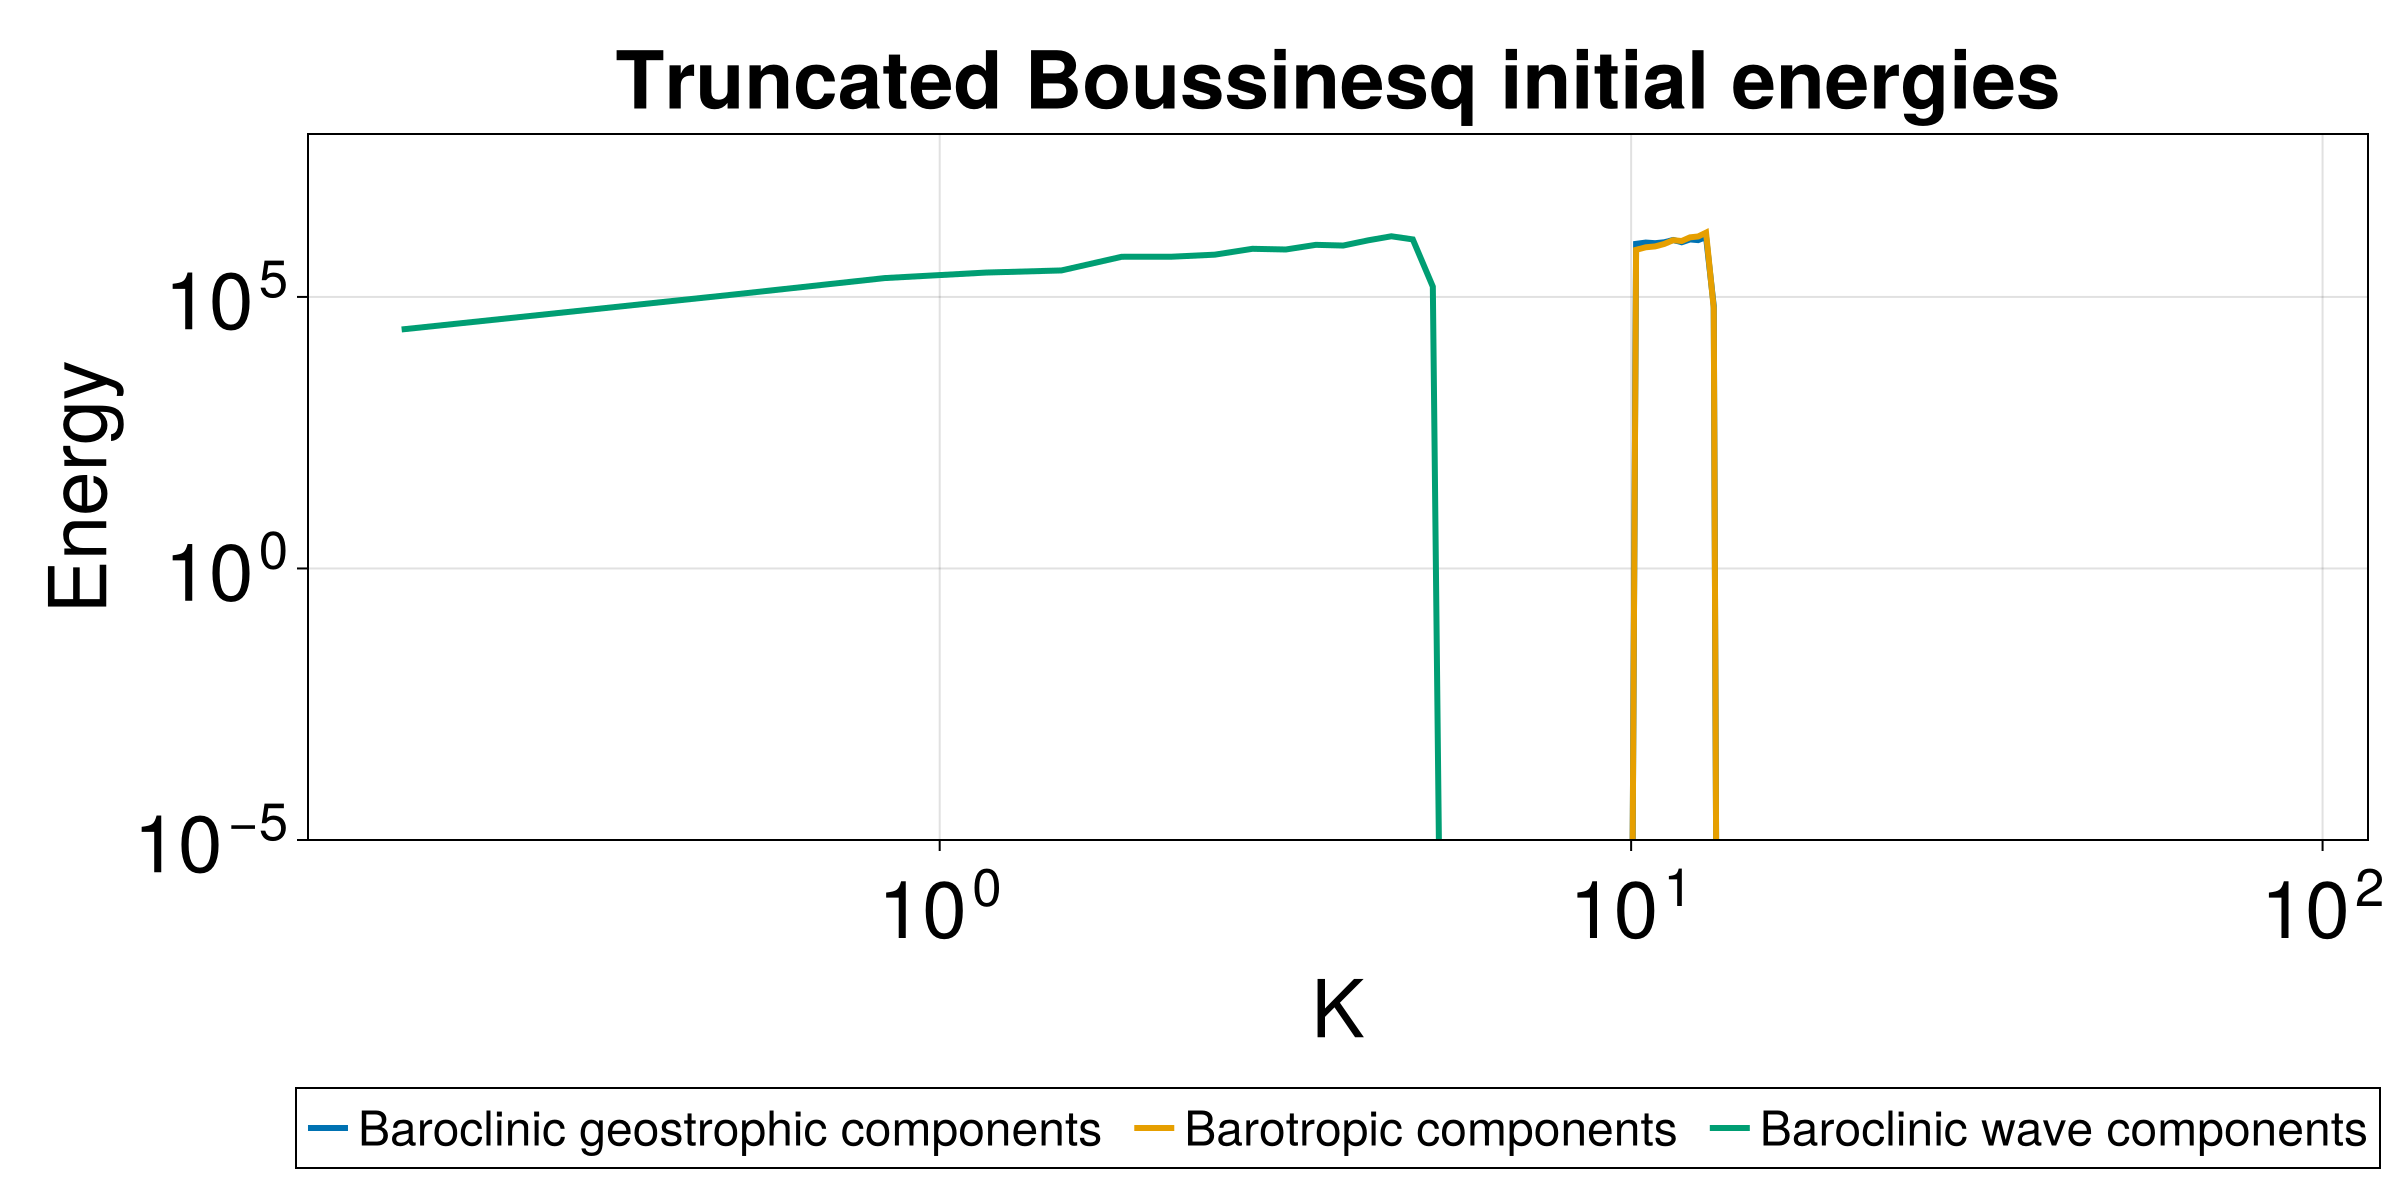

In [62]:
f = Figure(size=(1200, 600), fontsize=40)
ax = Axis(f[1,1], title="Truncated Boussinesq initial energies", xscale=log10, yscale=log10, xlabel="K", ylabel="Energy",
limits=(nothing, (1e-5, 1e8)))
geo_data = pg_data + ug_data + vg_data
trop_data = ut_data + vt_data
wave_data = uw_data + vw_data + pw_data

lines!(ax, k_values[1:256], replace!(geo_data, 0.0=>NaN), label="Baroclinic geostrophic components", linewidth=3)
lines!(ax, k_values[1:256], replace!(trop_data, 0.0=>NaN), label="Barotropic components", linewidth=3)
lines!(ax, k_values[1:256], replace!(wave_data, 0.0=>NaN), label="Baroclinic wave components", linewidth=3)
f[2, 1] = Legend(f, ax, labelsize=24, orientation = :horizontal)

f

In [10]:
diagnostics = jldopen("/scratch/nad9961/twolayer_simulation/45984910/diagnostic_file.jld2")
t = diagnostics["diagnostics/energy/t"]
data = diagnostics["diagnostics/energy/data"]
ke = zeros(length(t), 2)
pe = zeros(length(t))
for i=1:length(data)
    ke[i,:] = data[i][1]
    pe[i] = data[i][2] 
end

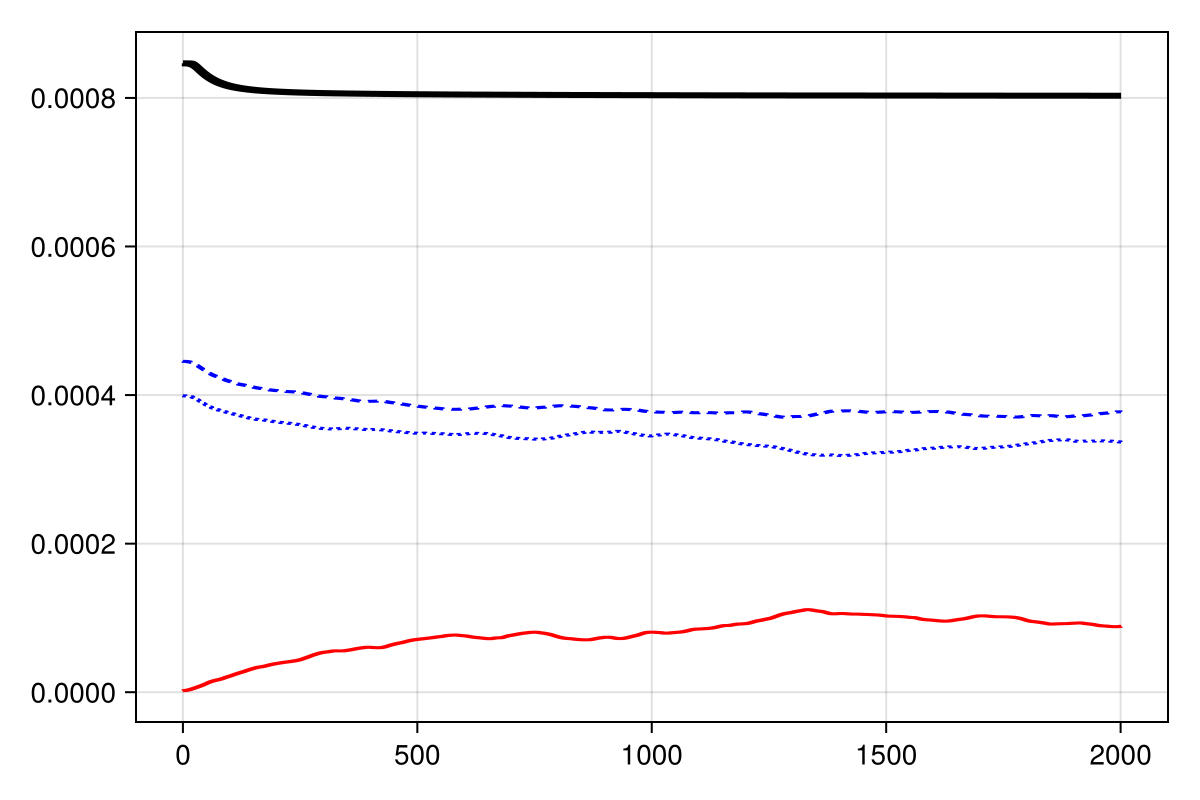

In [16]:
f = Figure(size=(600, 400))
ax = Axis(f[1,1])
lines!(t, ke[:,1], color="blue", linestyle=:dash)
lines!(t, ke[:,2], color="blue", linestyle=:dot)
lines!(t, pe, color="red")

lines!(t, ke[:,1] + ke[:,2] + pe, linewidth=3, color="black")
f

In [2]:
using Printf
using JLD2
include("load_file.jl")

# I'm not really sure which run this was supposed to be
#filename_func(idx) = @sprintf("/scratch/nad9961/twolayer_raytracing/47543207/packets.jld2.%08d", idx)
#t1, x1, k1, u1 = load_packet_analysis_files(filename_func, 0:35, true)

# This is a run to t=7763.4 with freely evolving background flow
#filename_func(idx) = @sprintf("/scratch/nad9961/twolayer_raytracing/47645940/packets.jld2.%08d", idx)
#initial_condition_file = "/scratch/nad9961/twolayer_raytracing/47645940/initial_condition.jld2"
#t1, x1, k1, u1 = load_packet_analysis_files(filename_func, 0:230, true)

# This is a run to t = 1200 with freely evolving background flow
#filename_func(idx) = @sprintf("/scratch/nad9961/twolayer_raytracing/47498728/packets.jld2.%08d", idx)
#t2, x2, k2, u2 = load_packet_analysis_files(filename_func, 0:29, true)

# This is the run that I used for my oral presentations that pretty clearly shows a nice power law
#t2, x2, k2, u2 = load_packet_analysis_file("../data/packets_N400_1.jld2", true)

# This run has a steady background flow to t=336, so the packets should conserve absolute frequency
#filename_func(idx) = @sprintf("/scratch/projects/shaferlab/nick/twolayer_raytracing/steady-flow/packets.jld2.%08d", idx)
#t1, x1, k1, u1 = load_packet_analysis_files(filename_func, 0:2, true)

# This run is steady background to t=8000.
#filename_func(idx) = @sprintf("/scratch/nad9961/twolayer_raytracing/50662698/packets.jld2.%08d", idx)
#t1, x1, k1, u1 = load_packet_analysis_files(filename_func, 0:3, true)

# This is the raytracing run corresponding to the job array raytracing run
#filename_func(idx) = @sprintf("/scratch/nad9961/swqg/51929320/15/packets.%06d.jld2", idx)
#t1, x1, k1, u1 = load_packet_analysis_files_collated(filename_func, [0,56], true)


# This is the raytracing run corresponding to the job array raytracing run
#filename_func(idx) = @sprintf("/scratch/nad9961/swqg/52240729/5/packets.%06d.jld2", idx)
#t1, x1, k1, u1 = load_packet_analysis_files_collated(filename_func, 0:11; packet_idxs=1:128, load_velocity=true)
#ag = 0.5
#Cg = 0.5
#f0 = 3.0 * Cg

filename_func(idx) = @sprintf("/scratch/nad9961/swqg/52275271/12/packets.%06d.jld2", idx)
t1, x1, k1, u1 = load_packet_analysis_files_collated(filename_func, 0:4; load_velocity=true)
ag1 = 0.5
Cg1 = 1.2
f01 = 3.0 * Cg1

filename_func(idx) = @sprintf("/scratch/nad9961/swqg/52275271/4/packets.%06d.jld2", idx)
t2, x2, k2, u2 = load_packet_analysis_files_collated(filename_func, 0:1; load_velocity=true)
ag2 = 0.5
Cg2 = 0.4
f02 = 3.0 * Cg2

filename_func(idx) = @sprintf("/scratch/nad9961/swqg/52275271/8/packets.%06d.jld2", idx)
t3, x3, k3, u3 = load_packet_analysis_files_collated(filename_func, 0:2; load_velocity=true)
ag3 = 0.5
Cg3 = 0.8
f03 = 3.0 * Cg3

16384, 5337
Reading file: /scratch/nad9961/swqg/52275271/12/packets.000000.jld2
Reading file: /scratch/nad9961/swqg/52275271/12/packets.000001.jld2
Reading file: /scratch/nad9961/swqg/52275271/12/packets.000002.jld2
Reading file: /scratch/nad9961/swqg/52275271/12/packets.000003.jld2
Reading file: /scratch/nad9961/swqg/52275271/12/packets.000004.jld2
16384, 1777
Reading file: /scratch/nad9961/swqg/52275271/4/packets.000000.jld2
Reading file: /scratch/nad9961/swqg/52275271/4/packets.000001.jld2
16384, 3559
Reading file: /scratch/nad9961/swqg/52275271/8/packets.000000.jld2
Reading file: /scratch/nad9961/swqg/52275271/8/packets.000001.jld2
Reading file: /scratch/nad9961/swqg/52275271/8/packets.000002.jld2


2.4000000000000004

In [76]:
# Test the background flow velocity
using FourierFlows

grid = TwoDGrid(; nx=512, Lx=2π)
initial_condition = jldopen("/scratch/nad9961/swqg/52245987/9/qgsw.000000.jld2")
final_condition = jldopen("/scratch/nad9961/swqg/52245987/9/qgsw.000000.jld2")
last_key = keys(final_condition["snapshots/sol"])[end]
qh = final_condition["snapshots/sol/" * last_key]
ψh = @. -qh /(grid.Krsq + initial_condition["params/Kd2"])
uh = -1im * grid.l  .* ψh
vh =  1im * grid.kr .* ψh
u = irfft(uh, grid.nx)
v = irfft(vh, grid.nx)

U_rms = sum(sqrt.(u.^2 + v.^2)) / size(u,1)/size(u,2)

0.14021310109986743

In [77]:
println("RMS Fr: ", U_rms/Cg)

RMS Fr: 0.14021310109986743


In [4]:
 final_condition["snapshots/sol"]

JLD2.Group
 ├─🔢 0
 ├─🔢 164920
 ├─🔢 166005
 ├─🔢 167090
 ├─🔢 168175
 ├─🔢 169260
 ├─🔢 170345
 ├─🔢 171430
 ├─🔢 172515
 └─ ⋯ (1431 more entries)

In [19]:
qh0 = final_condition["snapshots/sol/172515"]
ψh0 = @. -qh0 /(grid.Krsq + initial_condition["params/Kd2"])
#f0 = initial_condition["params/f"]
uh0 = -1im * grid.l  .* ψh
vh0 =  1im * grid.kr .* ψh
ρ, Eq0 = FourierFlows.radialspectrum(abs2.(sqrt.(Array(grid.Krsq)) .* ψh0), grid)
#lines(ρ, Eq0[:].+1e-6; axis=(;xscale=log10, yscale=log10))
q = irfft(qh0, grid.nx)
heatmap(q, colormap=:balance)

LoadError: KeyError: key "f" not found

In [3]:
#baroclinic_forced  = sum(sqrt.(u2[:,:,1].^2 + u2[:,:,2].^2)) / size(u2,1)/size(u2,2)
freely_evolving_rms = sum(sqrt.(u1[:,:,1].^2 + u1[:,:,2].^2)) / size(u1,1)/size(u1,2)
println(freely_evolving_rms)
#println(baroclinic_forced)

0.05670712013148951


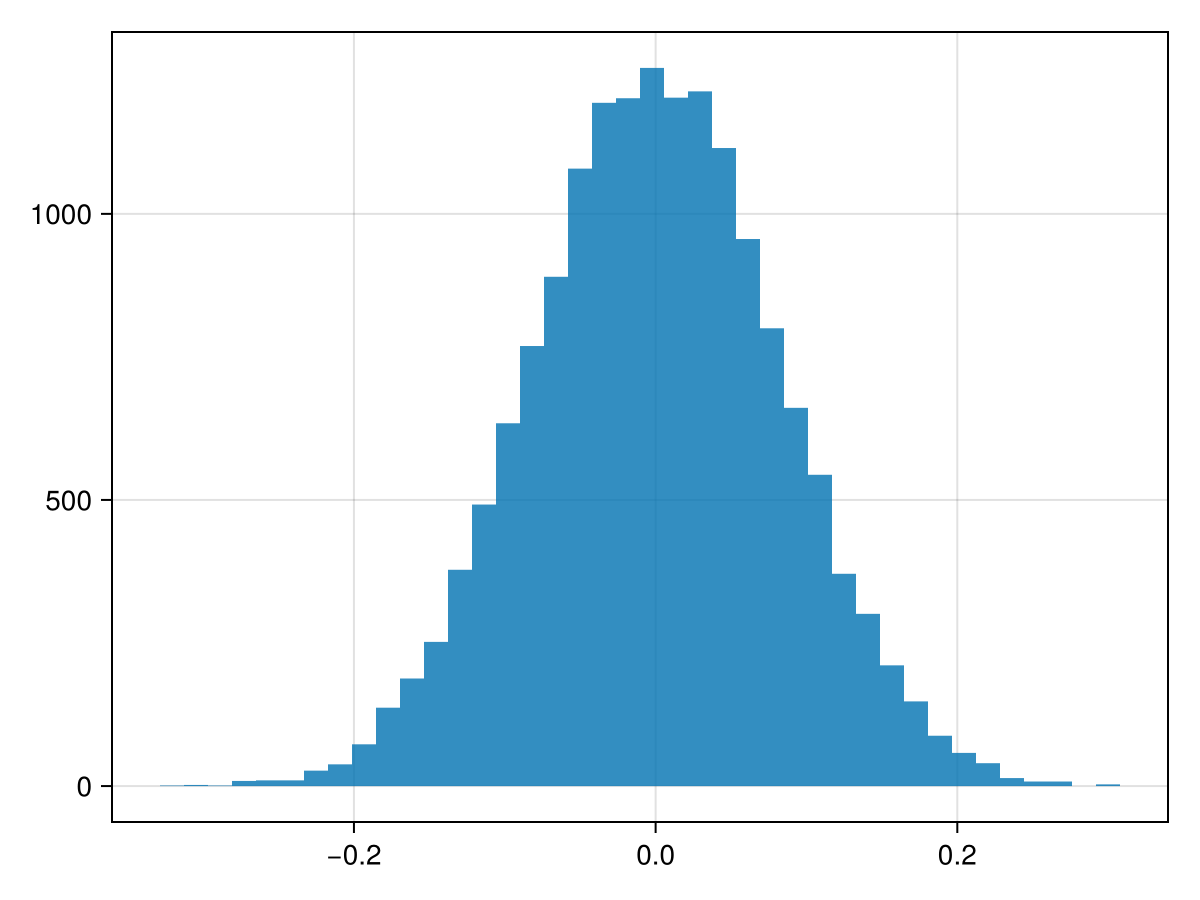

In [96]:
hist(u1[1,:,1][:], bins=40)

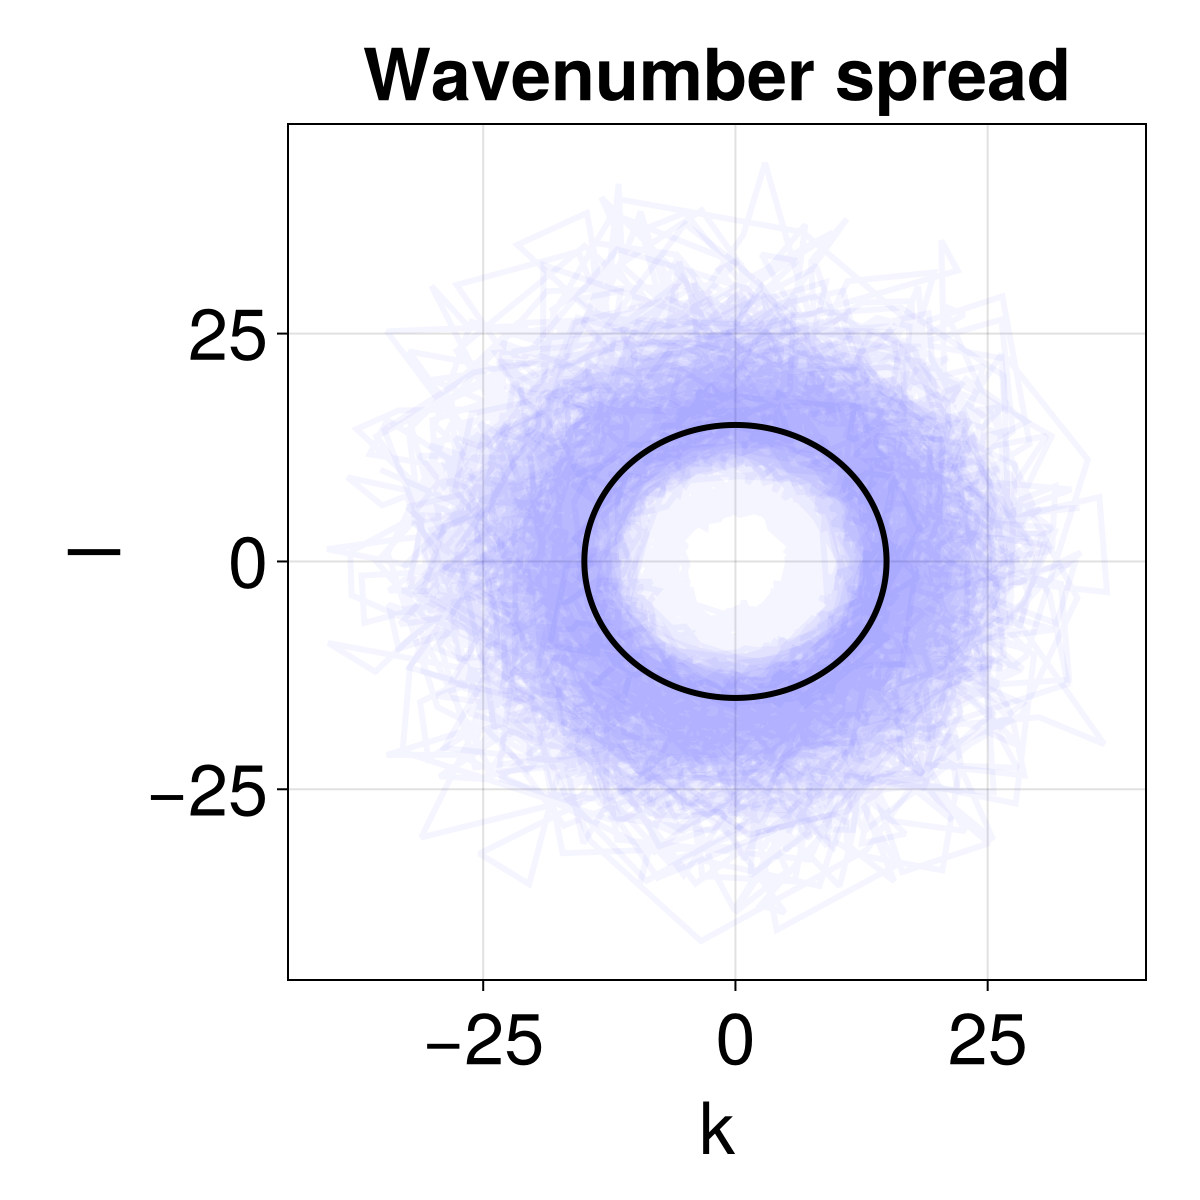

In [3]:
using CairoMakie

k = k1
fig1 = Figure(size=(600, 600), fontsize=36)
ax1 = Axis(fig1[1, 1]; title = "Wavenumber spread", xlabel="k", ylabel="l", aspect=1)
for i=1:10
    lines!(ax1, k[:,i,1], k[:,i,2], color="blue", alpha=4e-2, linewidth=3)
end
lines!(ax1, k[1,:,1], k[1,:,2], color="black", linewidth=3)

#save("QG_wavenumber_spread.png", fig1)
fig1

In [4]:
k = k1
u = u1
t = t1
Ω = sqrt.(f0^2 .+ Cg^2*(k[:,:,1].^2 + k[:,:,2].^2)) + sum(u .* k, dims=3)[:,:,1]
Ω0 = Ω[1, :]
Ω = Ω[2:end, :]
println(size(Ω))
println(maximum(abs.(Ω .- Ω0') ./ Ω0'))

LoadError: UndefVarError: `f0` not defined

In [5]:

fig2 = Figure(size=(800, 600), fontsize = 36, figure_padding = 30)
ax2 = Axis(fig2[1, 1]; 
        title = "Relative change in absolute frequency", xlabel="ft", ylabel="(Ω - Ω₀)/Ω₀"
        #limits = ((0, maximum(t1)), (-1., 5.))
)
for i=1:10
    initial_omega = Ω[1,i]
    lines!(ax2, t[2:end], (Ω[:, i] .- initial_omega) / initial_omega, linewidth=3)
end

#save("QG_absolute_frequency.png", fig2)
fig2

LoadError: UndefVarError: `Ω` not defined

In [6]:
size(u)

(5337, 16384, 2)

In [7]:
idx1 = Observable(2)
x_points = @lift(mod.(x1[$idx1,:,1], 2π).-π)
y_points = @lift(mod.(x1[$idx1,:,2], 2π).-π)
u_data = @lift(u1[$idx1,:,1])
fig, ax, sc = scatter(x_points, y_points, color=u_data, colormap=:balance, markersize=5, marker=:rect)
frames = 1:10:size(u,1)

CairoMakie.record(fig, "zonal_rays.mp4", frames, framerate=12) do idx
    idx1[] = idx
end

"zonal_rays.mp4"

In [8]:
scatter(final_x, final_y, color=final_u, colormap=:balance, markersize=5, marker=:rect)

LoadError: UndefVarError: `final_u` not defined

In [9]:
println(maximum(initial_u))
println(minimum(initial_u))
println(maximum(final_u))
println(minimum(final_u))

LoadError: UndefVarError: `initial_u` not defined

In [10]:
function generate_log_bins(min_ω, max_ω, nbins)
    start = log10(min_ω)
    fin = log10(max_ω)
    dω = (fin - start)/nbins
    log_bin_edges = start .+ (0:nbins)*dω
    return exp10.(log_bin_edges)
end

function generate_bins(min_ω, max_ω, nbins)
    start = min_ω
    fin = max_ω
    dω = (max_ω - min_ω)/nbins
    return start .+ (0:nbins)*dω
end


function hist_counts(data, bin_edges)
    counts = zeros(length(bin_edges)-1, size(data, 1))
    for bin_idx=1:(length(bin_edges)-1)
        counts[bin_idx, :] = sum(bin_edges[bin_idx] .<= data .< bin_edges[bin_idx+1], dims=2)
    end
    return counts
end

hist_counts (generic function with 1 method)

In [11]:
bin_edges = generate_bins(1, 100, 200)
bin_locs = (bin_edges[2:end] + bin_edges[1:end-1])/2
ω  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2))
hist_counts(ω[1:100:end,:], bin_edges)

200×54 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      0.0   0.0   0.0   0.0   1.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      1.0   1.0   0.0   1.0   0.0   0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0      1.0   0.0   2.0   0.0   0.0   2.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0      7.0   8.0   5.0   6.0   7.0   6.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  15.0  16.0  18.0  17.0  18.0  14.0
 0.0  0.0  0.0  2.0  0.0  1.0  3.0     24.0  21.0  20.0  21.0  22.0  26.0
 0.0  0.0  2.0  0.0  4.0  3.0  3.0     33.0  38.0  37.0  38.0  43.0  41.0
 ⋮            

In [12]:
ω  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(1 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

bin_edges = generate_bins(1, 100, 1000)
bin_locs = (bin_edges[2:end] + bin_edges[1:end-1])/2
ω_pdf = hist_counts(ω[1:100:end,:], bin_edges)
ω_abs_pdf = hist_counts(ω_abs[1:100:end,:], bin_edges)

1000×54 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [13]:
ω_pdf[:,1] .* bin_locs

1000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [14]:
fig3 = Figure(size=(1200, 800), fontsize=36, figure_padding=30)
ax3 = Axis(fig3[1, 1], xscale = log10, yscale = log10, 
        xlabel = "ω/f",
        ylabel = "Energy",
        #limits = ((1, 250), (1e-2, 10)),
        yticks = [0.1, 1., 10.],
        xminorticks = IntervalsBetween(10),
        xminorticksvisible=true,
        yminorticks = IntervalsBetween(10),
        yminorticksvisible=true,
        xticks = ([1, 10, 100], ["1", "10", "100"]))
width=20
starts = [100, 200, 300, 400, 420]
for idx=starts
#lines!(ax3, bin_locs, replace(ω_pdf[:,1] .* bin_locs, 0.0=>NaN), label=@sprintf("ft=%.1f", t[1]))
    lines!(ax3, bin_locs, replace((sum(ω_pdf[:,idx-width:idx+width], dims=2)[:] .* bin_locs)/width, 0.0=>NaN), label=@sprintf("ft=%.1f", t[idx]))
end
#lines!(ax3, bin_locs, 10000*bin_locs.^(-2.00), color="black", linestyle=:dashed)
#lines!(ax3, bin_locs, 1000*bin_locs.^(-1.00), color="black", linestyle=:dashed)


#axislegend()
fig3

LoadError: BoundsError: attempt to access 1000×54 Matrix{Float64} at index [1:1000, 80:120]

In [15]:
t = t1
x = x1
k = k1
u = u1

ω  = @. sqrt(9 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(9 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(9 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

bin_edges = generate_bins(1, 100, 200)
bin_locs = (bin_edges[2:end] + bin_edges[1:end-1])/2
ω_pdf = hist_counts(ω, bin_edges)
ω_abs_pdf = hist_counts(ω_abs, bin_edges)

function find_index(time, t, size)
    idx = findfirst(x -> x >= (time), t)[1]
    return idx - Int(floor(size/2))
end

function compute_energy(fω, start, fin, step)
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
end

using Printf
title = Observable(@sprintf("Energy spectrum (t=%.2f)", 0.))
fig3 = Figure(size=(1200, 800), fontsize=36, figure_padding=30)
ax3 = Axis(fig3[1, 1], xscale = log10, yscale = log10, 
        title = title,
        xlabel = "ω/f",
        ylabel = "Energy",
        limits = ((1, 250), (1e-2, 10)),
        yticks = [0.1, 1., 10.],
        xminorticks = IntervalsBetween(10),
        xminorticksvisible=true,
        yminorticks = IntervalsBetween(10),
        yminorticksvisible=true,
        xticks = ([1, 10, 100], ["1", "10", "100"]))
start_w = 1
fin_w = 100
ω_trend = start_w:0.1:fin_w
# slope = -2.25
slope = -2.00
trend = ω₀[1]*(1/3.5)^(slope)*ω_trend.^(slope)

N_lines = 1
#desired_times = [100., 300., 600., 900., 1200., 1500., 1800., 2100., 2400., 2700.]

#desired_times = [2900.]
step_end = 1
get_index(time) = find_index(time, t, step_end)
#starts = get_index.(desired_times)
#starts = [1, 10000, 30000, 50000, 70000]
#ends = starts .+ step_end
step = 1

initial_value_dot = scatter!(ax3, ω₀[1], ω₀[1], color="black", label="ft = 0", markersize=30, marker=:circle)
translate!(initial_value_dot, 0, 0, 1)

time_step = 10
frames = 1:floor(Int, (maximum(t)-100) / time_step-1)
lines!(ax3, ω_trend, trend, color="black", linestyle=:dash, label=rich("ω", superscript(@sprintf("%.2f", slope))); linewidth=5)
fω_plot = Observable([1.])
fω_abs_plot = Observable([1.])
energy_plot = Observable([1.])
energy_abs_plot = Observable([1.])
lines!(ax3, fω_plot, energy_plot, xscale=:log10, yscale=Makie.pseudolog10; linewidth=5, label="relative freq")#, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
lines!(ax3, fω_abs_plot, energy_abs_plot, xscale=:log10, yscale=Makie.pseudolog10; linewidth=5, label="abs freq")#, linestyle=:dash, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
axislegend(ax3, position=:lb, patchsize=(40., 20.))
println(length(frames))
CairoMakie.record(fig3, "spectrum_movie_U=0.1.mp4", frames, framerate = 18) do j
    desired_time =  j*time_step
    get_index(time) = find_index(desired_time, t, step_end)
    start = get_index(desired_time)
    ei = start + step_end
    #start = starts[i]
    #ei = ends[i]
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
    energy = (fω .* sum(mask,dims=2))[:] / length(fω)
    fω_abs = sort(ω_abs[start:step:ei,:][:])
    
    mask = (fω_abs' .>= (fω_abs .- 1)) .* (fω_abs' .<= (fω_abs .+ 1))
    energy_abs = (fω .* sum(mask,dims=2))[:] / length(fω_abs)
    
    fω_plot[] = fω
    fω_abs_plot[] = fω_abs
    energy_plot[] = energy
    energy_abs_plot[] = energy_abs
    title[] = @sprintf("Energy spectrum (t=%.2f)", desired_time)
end

save("energy_plot_barotropic_U=0.1.png", fig3)
fig3

LoadError: InterruptException:

In [16]:
t = t2
x = x2
k = k2
u = u2

ω  = @. sqrt(9 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(9 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(9 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

1777×16384 Matrix{Float64}:
  4.35405   4.44345   4.5619   …   4.6988   4.66159  4.65514  4.69112
  4.98178   4.96376   4.91824      5.14779  5.22245  5.27893  5.32949
  4.66728   4.58952   4.50406      5.87516  6.505    6.71488  6.88067
  4.6864    4.65299   4.66492      7.93425  9.44135  9.66597  9.7716
  5.18106   5.15325   5.18769      7.28702  8.46325  8.45906  8.18663
  7.0556    7.34737   7.84813  …   5.89825  5.49897  5.38007  5.34062
 10.1728    7.14828   8.61081      6.4325   4.67857  4.57296  4.63372
  7.63583   4.89876   5.88225      8.03004  4.5291   3.97259  4.92228
  6.96804   4.78159   5.6606       9.91665  6.47435  3.70002  5.70331
  8.11355   4.71933   6.48704      8.85343  4.48608  4.17275  4.37806
  8.49762   4.32967   7.06264  …   7.03966  5.59208  4.22167  4.04388
  8.40398   5.2339    6.83999      5.69214  6.11575  3.96458  4.14538
  8.43082   5.70286   6.7151       5.28484  7.05657  4.15373  4.14802
  ⋮                            ⋱   ⋮                          


In [17]:
t = t1
x = x1
k = k1
u = u1

ω  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(1 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

function find_index(time, t, size)
    idx = findfirst(x -> x >= (time), t)[1]
    return idx - Int(floor(size/2))
end

function compute_energy(fω, start, fin, step)
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
end

using Printf
title = Observable(@sprintf("Energy spectrum"))
fig3 = Figure(size=(1200, 800), fontsize=36, figure_padding=30)
ax3 = Axis(fig3[1, 1], xscale = log10, yscale = log10, 
        title = title,
        xlabel = "ω/f",
        ylabel = "Energy",
        limits = ((1, 60), (1e-2, 10)),
        yticks = [0.1, 1., 10.],
        xminorticks = IntervalsBetween(10),
        xminorticksvisible=true,
        yminorticks = IntervalsBetween(10),
        yminorticksvisible=true,
        xticks = ([1, 10, 100], ["1", "10", "100"]))
start_w = 1
fin_w = 100
ω_trend = start_w:0.1:fin_w
# slope = -2.25
slope = -2.00
trend = ω₀[1]*(1/3.5)^(slope)*ω_trend.^(slope)

N_lines = 600
desired_times = (1:N_lines) * 7000. / N_lines

#desired_times = [1000., 2000., 3000., 4000., 5000., 6000., 7000.]

#desired_times = [2900.]
step_end = 1
get_index(time) = find_index(time, t, step_end)
#starts = get_index.(desired_times)
#starts = [1, 10000, 30000, 50000, 70000]
#ends = starts .+ step_end
step = 10

initial_value_dot = scatter!(ax3, ω₀[1], ω₀[1], color="black", label="ft = 0", markersize=30, marker=:circle)
translate!(initial_value_dot, 0, 0, 1)

time_step = 1
frames = 1:floor(Int, (maximum(t)-100) / time_step-1)
lines!(ax3, ω_trend, trend, color="black", linestyle=:dash, label=rich("ω", superscript(@sprintf("%.2f", slope))); linewidth=5)
fω_plot = Observable([1.])
fω_abs_plot = Observable([1.])
energy_plot = Observable([1.])
energy_abs_plot = Observable([1.])
axislegend(ax3, position=:lb, patchsize=(40., 20.))
println(length(frames))
#CairoMakie.record(fig3, "spectrum_movie_U=0.1.mp4", frames, framerate = 18) do j
for desired_time=desired_times
    #desired_time =  j*time_step
    get_index(time) = find_index(desired_time, t, step_end)
    start = get_index(desired_time)
    ei = start + step_end
    #start = starts[i]
    #ei = ends[i]
    fω = sort(ω_abs[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
    energy = (fω .* sum(mask,dims=2))[:] / length(fω)
    #fω_abs = sort(ω_abs[start:step:ei,:][:])
    #mask = (fω_abs' .>= (fω_abs .- 2)) .* (fω_abs' .<= (fω_abs .+ 2))
    #energy_abs = (fω .* sum(mask,dims=2))[:] / length(fω_abs)
    
    #fω_plot[] = fω
    #fω_abs_plot[] = fω_abs
   # energy_plot[] = energy
    #energy_abs_plot[] = energy_abs
    if desired_time == desired_times[end]
        #lines!(ax3, fω, energy; linewidth=12, label=@sprintf("ft = %.0f", desired_time), color="black")
    end
    lines!(ax3, fω, energy; linewidth=5, label=@sprintf("ft = %.0f", desired_time), color="blue", alpha=(2e-2))
    #lines!(ax3, fω, energy; linewidth=5, label=@sprintf("ft = %.0f", desired_time), color="blue", alpha=(2e-1 + (desired_time/7000.)^6))#(t[start] + t[ei]) / 2))
    # lines!(ax3, fω_abs_plot, energy_abs_plot, xscale=:log10, yscale=Makie.pseudolog10; linewidth=5, label="abs freq")#, linestyle=:dash, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
    #title[] = @sprintf("Energy spectrum (t=%.2f)", desired_time)
end

#axislegend(ax3)

save("energy_plot_barotropic_U=0.1_free_evolve.png", fig3)
fig3

LoadError: InterruptException:

In [18]:
t

5337-element Vector{Float64}:
    0.0
  203.12939453125
  203.68460083007812
  204.23980712890625
  204.79501342773438
  205.3502197265625
  205.90542602539062
  206.46063232421875
  207.01583862304688
  207.571044921875
  208.12625122070312
  208.68145751953125
  209.23666381835938
    ⋮
 3141.0166015625
 3141.568359375
 3142.1201171875
 3142.671875
 3143.2236328125
 3143.775390625
 3144.3271484375
 3144.87890625
 3145.4306640625
 3145.982421875
 3146.5341796875
    0.0

In [19]:
function estimate_pdf(data, query_point, kernel, bandwidth)
    pointwise_contribution = sample -> kernel((sample - query_point)/bandwidth)
    return sum(pointwise_contribution, data)/length(data)/bandwidth
end

function gaussian_kernel(x)
    return 1/sqrt(2π)*exp(-x^2/2)
end

function epanechnikov_kernel(x)
    return (abs(x) <= 1) * 3/4. * (1-x^2)
end

function compute_plot_data(data)
    μ = sum(data) / length(data)
    σ = sqrt(sum((data .- μ).^2)/(length(data)-1))
    bandwidth = 1.06 * σ * length(data)^(-1/5) + 1e-2
    #println(bandwidth)
    query_start = minimum(data)/2
    query_end = 2*maximum(data)
    Npoints = max(100, 10000 * σ)
    #println(Npoints)
    linspace = (0:(Npoints-1))/(Npoints-1)
    #query_points = @. exp(log(query_start) + log(query_end-query_start)*linspace)
    query_points = @. query_start + (query_end - query_start)*linspace
    pdf = estimate_pdf.(Ref(data), query_points, gaussian_kernel, bandwidth)
    return query_points, pdf
end


compute_plot_data (generic function with 1 method)

In [20]:
ω  = @. sqrt(f0^2 + Cg^2*(k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω_abs  = @. sqrt(f0^2 + Cg^2*(k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
println(maximum(ω_abs))
println(minimum(ω_abs))
println(size(ω))

LoadError: UndefVarError: `f0` not defined

In [21]:
println(minimum(u[:,:,1].*k[:,:,1] + u[:,:,2].*k[:,:,2]))
println(maximum(sqrt.(f0^2 .+ Cg^2*(k[:,:,1].^2 + k[:,:,2].^2))))

-48.790004016334166


LoadError: UndefVarError: `f0` not defined

9


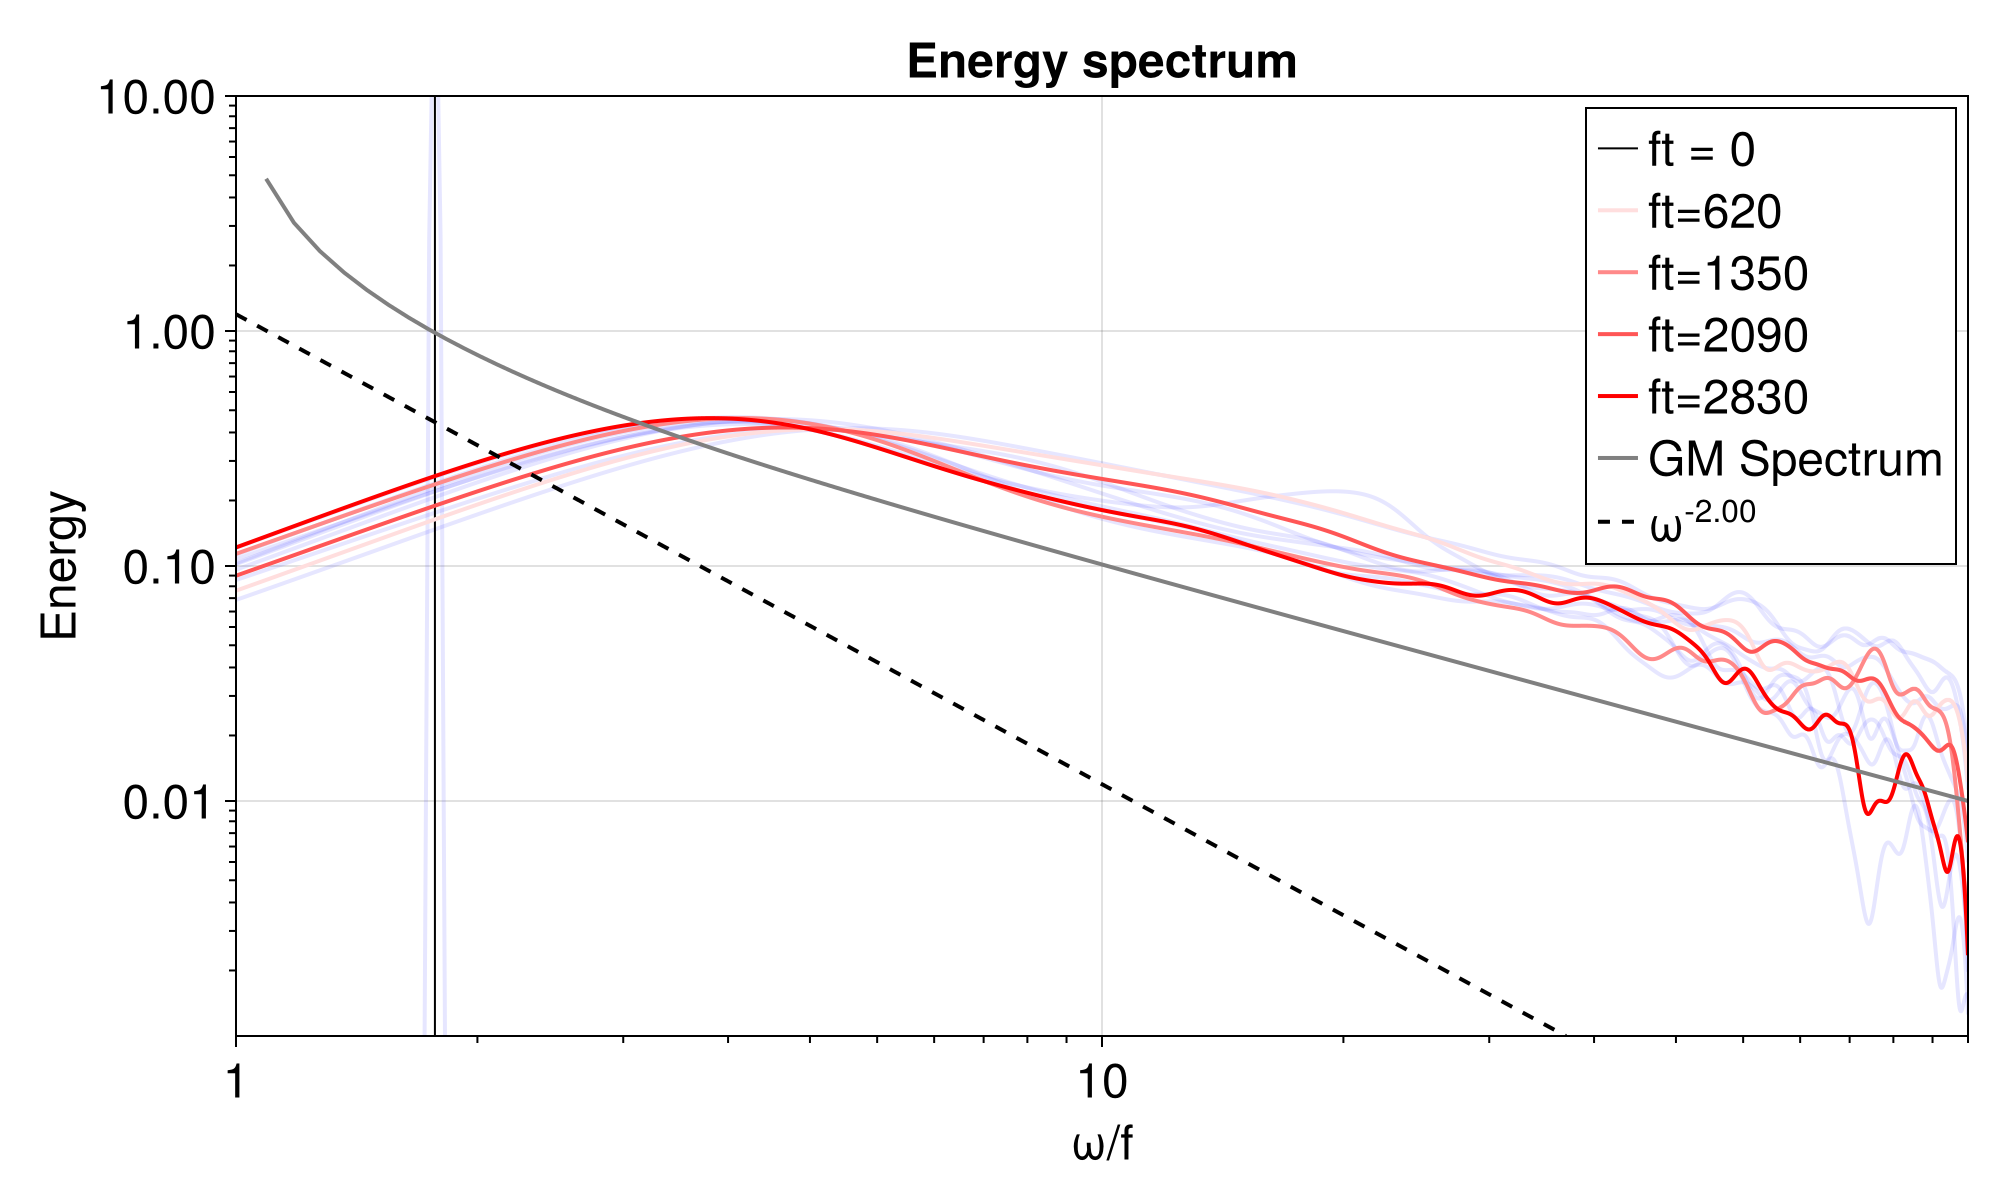

In [22]:
t = t2
x = x2
k = k2
u = u2
f0 = f02
Cg = Cg2

ω  = @. sqrt(f0^2 + Cg^2*(k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(f0^2 + Cg^2*(k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. abs.(sqrt(f0^2 + Cg^2*(k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2])


f = Figure(size=(1000, 600), fontsize=24)
ax = Axis(f[1,1]; xscale=log10, yscale=log10, xticks=[1, 10], yticks=[1e-2, 1e-1, 1, 10], limits=((1, 100), (1e-3, 10)),
 title = "Energy spectrum",
 xlabel = "ω/f",
 ylabel = "Energy",
 xminorticks = IntervalsBetween(10),
 xminorticksvisible=true,
 yminorticks = IntervalsBetween(10),
 yminorticksvisible=true)
#bandwidths = 0.1:0.3:1.2
#bandwidths = 0.01:0.01:0.05
idxs = 1:200:size(ω,1)
println(length(idxs))
for idx=idxs
    data = (ω[idx, :][:]/f0)
    query_points, pdf = compute_plot_data(data)
    lines!(ax, query_points, query_points .* pdf, color="blue", alpha=1e-1 + 0.9*(idx/size(ω,1))^(100), linewidth=2)
    #scatter!(ax, data, 1e-2 .* ones(length(data)), marker=:vline, markersize=10)
end

lines!(ax, ω₀[1]*ones(2)/f0, [1e-3, 10], color="black", linewidth=1, label="ft = 0")  

idxs = 250:ceil(Int, size(ω, 1)/4):size(ω, 1)
colors = ["#ffdede", "#ff8989", "#ff5656", "#ff0000"]
for i=1:length(idxs)
    idx = idxs[i]
    data = ω[idx, :][:]/f0
    query_points, pdf = compute_plot_data(data)
    lines!(ax, query_points, query_points .* pdf, linewidth=2, color=colors[i], label=@sprintf("ft=%.0f", floor(t[idx]/10)*10))
end

ω_trend = f0:0.1:(maximum(ω))
slope = -2.00
GM_trend = @. (ω_trend^2 + f0^2)/ω_trend * (f0/ω_trend*(ω_trend^2-f0^2)^(-1/2))
linear_trend = (ω₀[1]/f0)*(1.)^(slope)*ω_trend.^(slope)

lines!(ax, ω_trend/f0, GM_trend, color="gray", linestyle=:solid, label="GM Spectrum"; linewidth=2)
lines!(ax, ω_trend/f0, linear_trend, color="black", linestyle=:dash, label=rich("ω", superscript(@sprintf("%.2f", slope))); linewidth=2)

axislegend(ax)

f

In [80]:
size(t)

(25000,)

In [32]:
println(findfirst(t .> 500))
println(findfirst(t .> 1000))
println(findfirst(t .> 1500))
println(findfirst(t .> 2000))

CartesianIndex(205, 1)
CartesianIndex(409, 1)
CartesianIndex(613, 1)
CartesianIndex(816, 1)


In [23]:
ω  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2))# + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]
ω₀ = @. sqrt(1 + (k[1,:,1]^2 + k[1,:,2]^2))# + u[1,:,1]*k[1,:,1] + u[1,:,2]*k[1,:,2]
ω_abs  = @. sqrt(1 + (k[:,:,1]^2 + k[:,:,2]^2)) + u[:,:,1]*k[:,:,1] + u[:,:,2]*k[:,:,2]

function find_index(time, t, size)
    idx = findfirst(x -> x >= (time), t)[1]
    return idx - Int(floor(size/2))
end

function compute_energy(fω, start, fin, step)
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
end

using Printf
title = Observable(@sprintf("Energy spectrum (t=%.2f)", 0.))
fig3 = Figure(size=(1200, 800), fontsize=36, figure_padding=30)
ax3 = Axis(fig3[1, 1], xscale = log10, yscale = log10, 
        title = title,
        xlabel = "ω/f",
        ylabel = "Energy",
        limits = ((1, 250), (1e-2, 10)),
        yticks = [0.1, 1., 10.],
        xminorticks = IntervalsBetween(10),
        xminorticksvisible=true,
        yminorticks = IntervalsBetween(10),
        yminorticksvisible=true,
        xticks = ([1, 10, 100], ["1", "10", "100"]))
start_w = 1
fin_w = 1
ω_trend = start_w:0.1:fin_w
# slope = -2.25
slope = -2.00
trend = ω₀[1]*(1/3.5)^(slope)*ω_trend.^(slope)

N_lines = 1
#desired_times = [100., 300., 600., 900., 1200., 1500., 1800., 2100., 2400., 2700.]

#desired_times = [2900.]
step_end = 1
get_index(time) = find_index(time, t, step_end)
#starts = get_index.(desired_times)
#starts = [1, 10000, 30000, 50000, 70000]
#ends = starts .+ step_end
step = 1

initial_value_dot = scatter!(ax3, ω₀[1], ω₀[1], color="black", label="ft = 0", markersize=30, marker=:circle)
translate!(initial_value_dot, 0, 0, 1)

time_step = 500
frames = 1:floor(Int, maximum(t) / time_step-1)
println(frames[end])
lines!(ax3, ω_trend, trend, color="black", linestyle=:dash, label=rich("ω", superscript(@sprintf("%.2f", slope))); linewidth=5)
fω_plot = Observable([1.])
fω_abs_plot = Observable([1.])
energy_plot = Observable([1.])
energy_abs_plot = Observable([1.])
lines!(ax3, fω_plot, energy_plot, xscale=:log10, yscale=:log10; linewidth=5, label="relative freq")#, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
lines!(ax3, fω_abs_plot, energy_abs_plot, xscale=:log10, yscale=:log10; linewidth=5, label="abs freq")#, linestyle=:dash, label=@sprintf("ft = %.0f", (t[start] + t[ei]) / 2))
axislegend(ax3, position=:lb, patchsize=(40., 20.))
println(length(frames))
CairoMakie.record(fig3, "action_spectrum_movie_U=1.mp4", frames, framerate = 18) do j
    desired_time =  j*time_step
    get_index(time) = find_index(desired_time, t, step_end)
    start = get_index(desired_time)
    ei = start + step_end
    #start = starts[i]
    #ei = ends[i]
    fω = sort(ω[start:step:ei,:][:])
    mask = (fω' .>= (fω .- 1)) .* (fω' .<= (fω .+ 1))
    energy = sum(mask,dims=2)[:] / length(fω)
    
    fω_abs = sort(ω_abs[start:step:ei,:][:])
    mask = (fω_abs' .>= (fω_abs .- 1)) .* (fω_abs' .<= (fω_abs .+ 1))
    energy_abs = sum(mask,dims=2)[:] / length(fω_abs)
    
    fω_plot[] = fω
    fω_abs_plot[] = fω_abs
    energy_plot[] = energy
    energy_abs_plot[] = energy_abs
    title[] = @sprintf("Action spectrum (t=%.2f)", desired_time)
end


save("action_plot_barotropic_U=1.png", fig3)
fig3

5


LoadError: Invalid attributes [31m[1myscale[22m[39m and [31m[1mxscale[22m[39m for plot type [34m[1mLines{Tuple{Vector{Point{2, Float64}}}}[22m[39m.

The available plot attributes for Lines{Tuple{Vector{Point{2, Float64}}}} are:

alpha        cycle            inspector_hover  lowclip      ssao          
clip_planes  depth_shift      inspector_label  miter_limit  transformation
color        fxaa             joinstyle        model        transparency  
colormap     highclip         linecap          nan_color    visible       
colorrange   inspectable      linestyle        overdraw                   
colorscale   inspector_clear  linewidth        space                      


Generic attributes are:

clip_planes  dim_conversions  model      transformation  yautolimits        
cycle        label            rasterize  xautolimits     zautolimits        



In [50]:
Npackets = length(keys(ray_test_file["p/u"]))
KE = 0.0
for i=1:Npackets
    KE += sum(abs2.(ray_test_file["p/u/" * string(i) * "/200200"]))
end
KE /= Npackets
println(sqrt(KE))

0.08372883409963469


In [127]:
using FourierFlows
using FourierFlows: parsevalsum2
grid = TwoDGrid(; nx=ty_config_file["grid/nx"], Lx=ty_config_file["grid/Lx"])
snapshot_h = rfft(irfft(ty_test_file["snapshots/sol/25100"], grid.nx, (1, 2)), (1, 2))
#snapshot_h = ty_test_file["snapshots/sol/25100"]
ψt_h = -grid.invKrsq .* snapshot_h[:,:,1]
ut_h = -1im * grid.l  .* ψt_h
vt_h =  1im * grid.kr .* ψt_h
rms_Ut = sqrt(parsevalsum2(ut_h, grid) + parsevalsum2(vt_h, grid))
rms_Uc = sqrt(parsevalsum2(snapshot_h[:,:,2], grid) + parsevalsum2(snapshot_h[:,:,3], grid))
println(rms_Ut)
println(rms_Uc)

0.3144122233955411
0.39245302764013495


In [52]:
(0.3144122233955411/0.08372883409963469)^2

14.100962442334314

In [65]:
#initial_condition_sim = jldopen("/scratch/nad9961/twolayer_simulation/45984910/2layer_freely_evolving.jld2")
initial_condition_sim = jldopen("/home/nad9961/JuliaRaytracingSW/raytracing/initial_conditions/initial_condition_512x512_U=1.10_freely_evolve.jld2")

JLDFile /home/nad9961/JuliaRaytracingSW/raytracing/initial_conditions/initial_condition_512x512_U=1.10_freely_evolve.jld2 (read-only)
 ├─📂 eqn
 │  ├─🔢 L
 │  ├─🔢 dims
 │  └─🔢 T
 ├─📂 clock
 │  └─🔢 dt
 ├─📂 grid
 │  ├─🔢 nx
 │  └─ ⋯ (5 more entries)
 └─ ⋯ (2 more entries)

In [125]:
ψh_0 = rfft(irfft(initial_condition_sim["snapshots/ψh/595404"], grid.nx, (1, 2)))
u_h = -1im * grid.l  .* ψh_0
v_h =  1im * grid.kr .* ψh_0
ut_h = (u_h[:,:,1] + u_h[:,:,2])/2
vt_h = (v_h[:,:,1] + v_h[:,:,2])/2
ut = irfft(ut_h, grid.nx, (1, 2))
vt = irfft(vt_h, grid.nx, (1, 2))
rms_Ut = sqrt(parsevalsum2(ut_h, grid) + parsevalsum2(vt_h, grid))
println(sqrt(sum(ut.^2 + vt.^2) * grid.dx^2))
println(rms_Ut)

0.7311307025993378
0.7311307025993377


In [136]:
N_samples = 1000
velocity_total = 0.0
for i = 1:N_samples
    x, y = rand(2)
    x_idx = floor(Int, grid.nx * x) + 1
    y_idx = floor(Int, grid.nx * y) + 1
    u = ut[x_idx, y_idx]
    v = vt[x_idx, y_idx]
    KE += u^2 + v^2
end
KE /= N_samples
rms_velocity = sqrt(KE)

0.7208649373604877

In [76]:
x, y = rand(2)

2-element Vector{Float64}:
 0.7572648827920276
 0.51623463824335

In [46]:
initial_condition = jldopen("/scratch/nad9961/twolayer_simulation/45984910/initial_condition_512x512_U=1.10_freely_evolve.jld2")
ψh_0 = initial_condition["snapshots/ψh"]



JLD2.Group
 └─🔢 595404

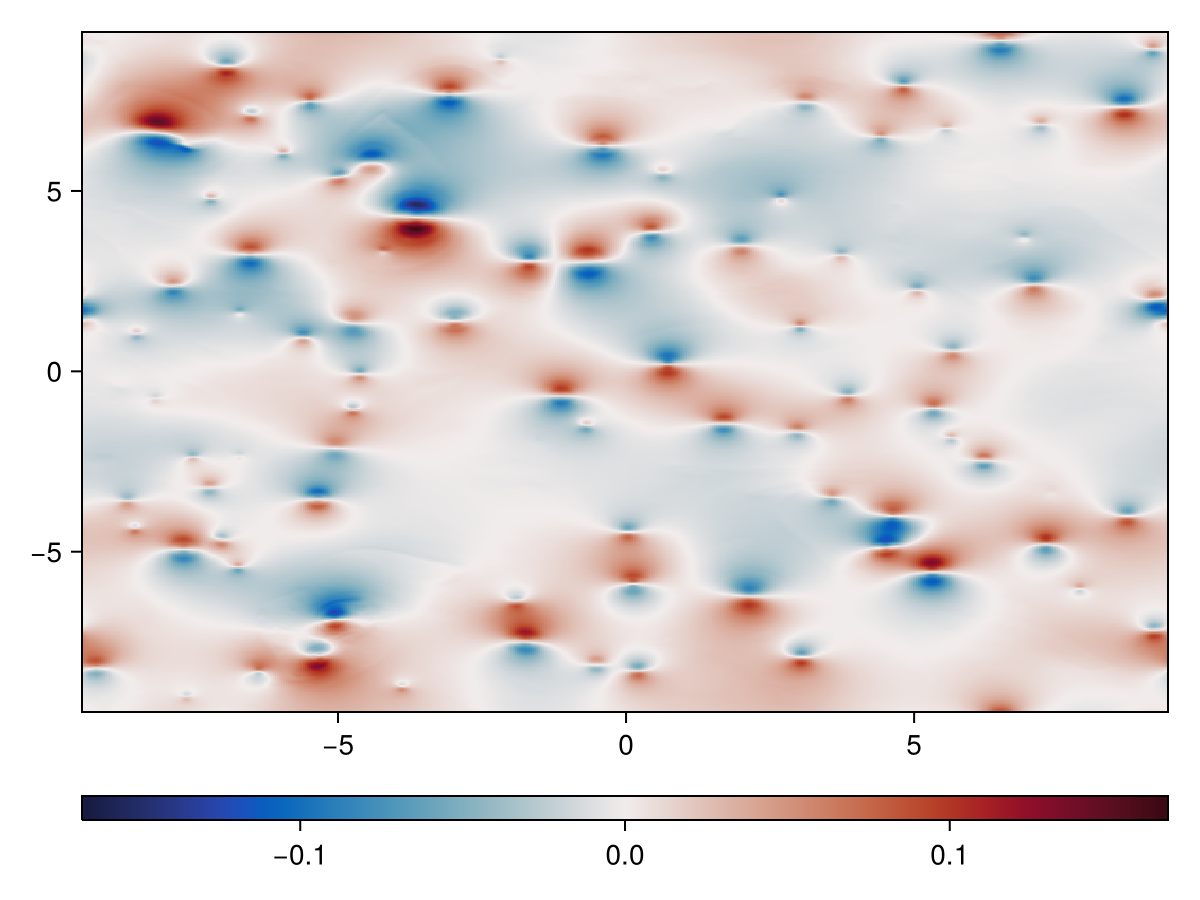

In [105]:
fig = Figure()
ax = Axis(fig[1,1][1,1])

ucolorrange = (-maximum(abs.(ut)), maximum(abs.(ut)))
uhm = heatmap!(ax, grid.x, grid.y, ut; colormap = :balance, colorrange=ucolorrange)
Colorbar(fig[1,1][2, 1], uhm, vertical=false, flipaxis = false)

fig